In [1]:
import logic.pulsed.pulse_objects as po
from logic.pulsed.sampling_functions import SamplingFunctions as SF
import time
import matplotlib.pyplot as plt
from tqdm import tqdm
pjl = pulsedjupyterlogic

In [2]:
#measurement parameters
init_pi_pulse = 66e-9 

#Driving information for the first LO (SMBV)
target_freq_0 = 2.44167e9
LO_freq_0 = target_freq_0 + 100e6
power_0 = -7.5


#Driving information for the second LO (SGS)
target_freq_1 = 3e9
LO_freq_1 = target_freq_1 + 100e6
power_1 = -100#-20.7

#additional information for save tag
tip_name = 'A-T17-12'
sample = 'NbSe2_S2'
temperature = '2.0K'
b_field = '200mT_Bnv'
contact = 'IC'
extra = 'set_E_t2_1D'

afm_scanner_logic.jupyter_meas_stop = False

###### Rabi, PODMR, HEcho

In [3]:
def run_podmr(max_sweeps, pos_tag):
    mw_start = 2.42e9
    mw_stop = 2.46e9
    mw_step = 1e6

    if LO_freq_0<mw_stop+mw_step:
        print('!!!Warning! LO Freq too low. Sweep is too large in range!!!\n\n\n')
    pjl.initialize_ensemble(pi_pulse=init_pi_pulse, LO_freq_0=LO_freq_0, target_freq_0=target_freq_0, power_0=power_0, LO_freq_1=LO_freq_1, target_freq_1=target_freq_1, power_1=power_1)
    pjl.PODMR(mw_start, mw_stop, mw_step)
    pjl.start_measurement(measurement_type='PODMR', tip_name=tip_name, sample=sample, 
                          temperature=temperature, b_field=b_field, contact=contact, extra=extra)
    time.sleep(2)
    while True:
        if pulsedmasterlogic.elapsed_sweeps>max_sweeps or afm_scanner_logic.jupyter_meas_stop:
            pulsedmeasurementlogic.stop_pulsed_measurement()
            fit_data, fit_result = pulsedmeasurementlogic.do_fit('gaussian')
            resonance = fit_result.params['center'].value
            tag = pulsedmeasurement._mw.save_tag_LineEdit.text()
            pulsedmeasurementlogic.save_measurement_data(tag=tag+pos_tag)
            return resonance
        else:
            time.sleep(1)

def run_rabi(resonance, max_sweeps, pos_tag):
    tau_start = 0
    tau_stop = 200e-9
    tau_num = 50
    
    target_freq_0 = resonance
    LO_freq_0 = target_freq_0 + 100e6

    pjl.initialize_ensemble(pi_pulse=init_pi_pulse, LO_freq_0=LO_freq_0, target_freq_0=target_freq_0, power_0=power_0, LO_freq_1=LO_freq_1, target_freq_1=target_freq_1, power_1=power_1)
    pjl.Rabi(tau_start, tau_stop, tau_num)
    pjl.start_measurement(measurement_type='Rabi', tip_name=tip_name, sample=sample, 
                          temperature=temperature, b_field=b_field, contact=contact, extra=extra)
    time.sleep(2)
    while True:
        if pulsedmasterlogic.elapsed_sweeps>max_sweeps or afm_scanner_logic.jupyter_meas_stop:
            pulsedmeasurementlogic.stop_pulsed_measurement()
            fit_data, fit_result = pulsedmeasurementlogic.do_fit('sin_exp')
            pi_pulse = 1/fit_result.params['frequency'].value/2
            tag = pulsedmeasurement._mw.save_tag_LineEdit.text()
            pulsedmeasurementlogic.save_measurement_data(tag=tag+pos_tag)
            return pi_pulse
        else:
            time.sleep(1)
            
def run_hecho(resonance, pi_pulse, max_sweeps, pos_tag):
    tau_start = 200e-9
    tau_stop = 10e-6
    tau_num = 100
    
    target_freq_0 = resonance
    LO_freq_0 = target_freq_0 + 100e6

    pjl.initialize_ensemble(pi_pulse=pi_pulse, LO_freq_0=LO_freq_0, target_freq_0=target_freq_0, power_0=power_0, LO_freq_1=LO_freq_1, target_freq_1=target_freq_1, power_1=power_1)
    pjl.Hecho_alt_phased(tau_start, tau_stop, tau_num)
    pjl.start_measurement(measurement_type='Hecho-alt-phased', tip_name=tip_name, sample=sample, 
                          temperature=temperature, b_field=b_field, contact=contact, extra=extra)
    time.sleep(2)
    pulsedmasterlogic.set_alternative_data_type('Delta')
    while True:
        if pulsedmasterlogic.elapsed_sweeps>max_sweeps or afm_scanner_logic.jupyter_meas_stop:
            pulsedmeasurementlogic.stop_pulsed_measurement()
            fit_data, fit_result = pulsedmeasurementlogic.do_fit('exp_decay_stretched', use_alternative_data=True)
            lifetime = fit_result.params['lifetime'].value
            tag = pulsedmeasurement._mw.save_tag_LineEdit.text()
            pulsedmeasurementlogic.save_measurement_data(tag=tag+pos_tag)
            data = pulsedmeasurementlogic.signal_alt_data[1]
            pulsedmasterlogic.set_alternative_data_type('None')
            return data
        else:
            time.sleep(1)

def measurement_loop(scan_start, scan_stop, scan_step, y_pos):
    scan_array = np.linspace(scan_start, scan_stop, scan_step)
    pos_data = []
    for idx, x_pos in enumerate(tqdm(scan_array)):
        while True:
            if spm._dev.base.getParameter(spm._dev.base.getConst('ID_SCAN_STATUS'), 0)==2:
                time.sleep(0.5)
            else:
                break
        afm_scanner_logic.set_afm_pos({'x':x_pos, 'y':y_pos})
        time.sleep(1)
        while True:
            if spm._dev.base.getParameter(spm._dev.base.getConst('ID_SCAN_STATUS'), 0)==2:
                time.sleep(0.5)
            else:
                break
        if afm_scanner_logic.jupyter_meas_stop:
            return 'Measurement force stopped'
        data = measurement(pos_tag=f'_pos_{x_pos,y_pos}_pos')
        pos_data.append(data)
    return pos_data
        
def measurement(pos_tag):
    resonance = run_podmr(200e3, pos_tag)
    pi_pulse = run_rabi(resonance, 200e3, pos_tag)
    data = run_hecho(resonance, pi_pulse, 650e3, pos_tag)
    return data

######  Run measurement

100%|#################################################################################| 50/50 [20:53:55<00:00, 1504.72s/it]


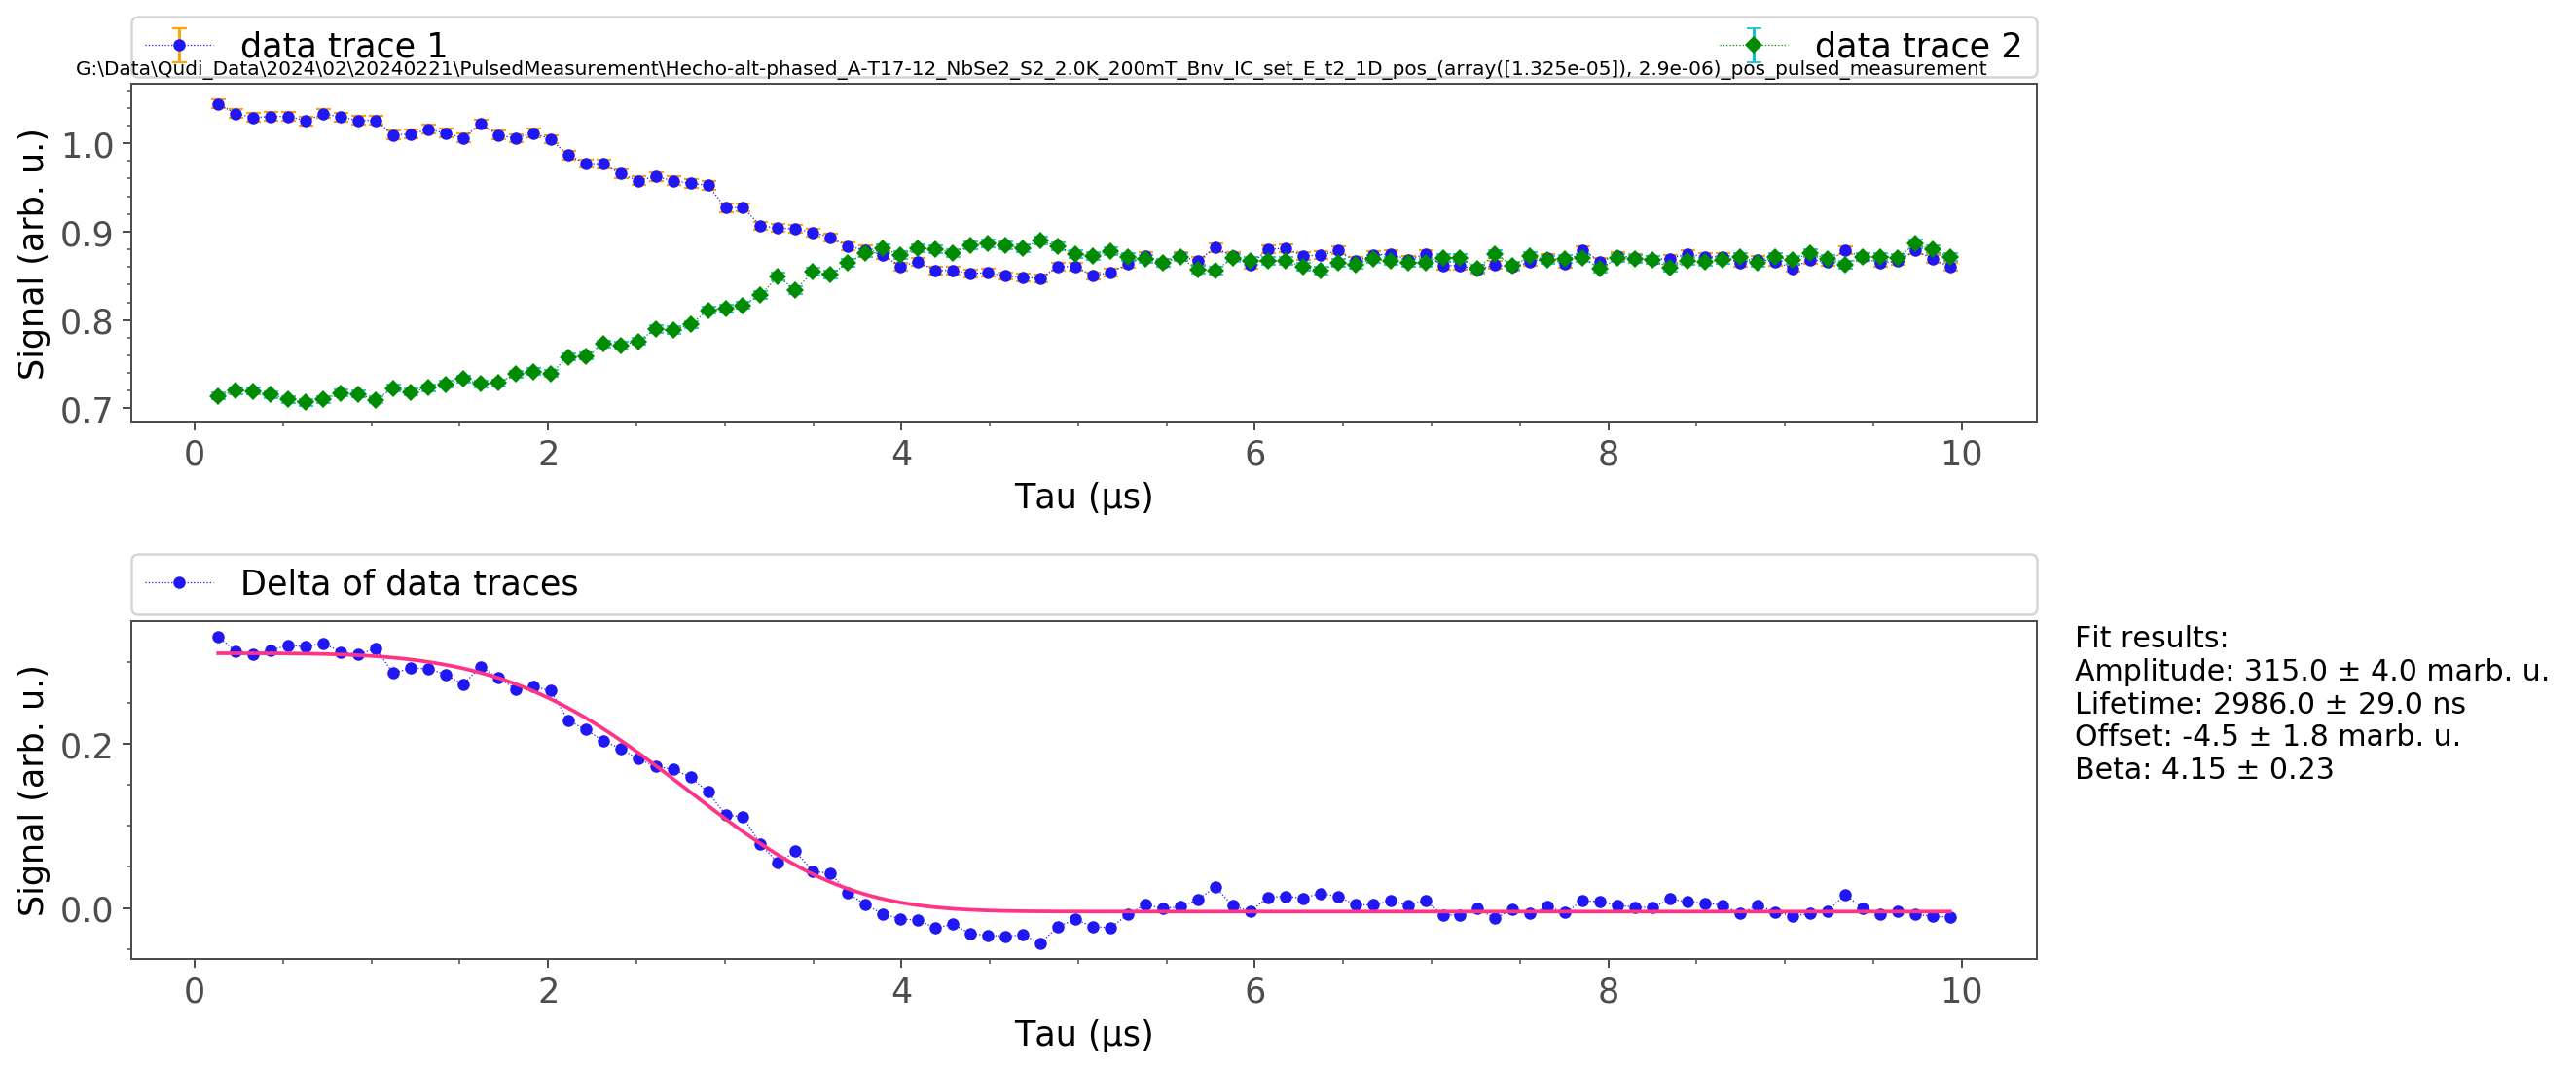

In [4]:
afm_scanner_logic.jupyter_meas_stop = False
scan_start=11.25e-6, 
scan_stop=13.25e-6, 
scan_step=50
y_pos=2.9e-6

tau_start = 200e-9
tau_stop = 10e-6
tau_num = 100

pos_data = measurement_loop(scan_start, scan_stop, scan_step, y_pos)

In [6]:
pos_data = np.asarray(pos_data)
comments = f'{tau_start,tau_stop,tau_num}\n{scan_start,scan_stop,scan_step}\n{np.linspace(scan_start,scan_stop,scan_step).T}\n{np.ones_like(np.linspace(scan_start,scan_stop,scan_step)).T*y_pos}'
path = savelogic.get_path_for_module('PulsedMeasurement\\') + pulsedmeasurement._mw.save_tag_LineEdit.text() + 'summary_comment.txt'
np.savetxt(path, pos_data.T, header=comments)

In [7]:
loc = "G:\\Data\\Qudi_Data\\2024\\02\\20240221\\PulsedMeasurement\\" + "Hecho-alt-phased_A-T17-12_NbSe2_S2_2.0K_200mT_Bnv_IC_set_E_t2_1Dsummary_comment.txt"
data = np.loadtxt(loc).T

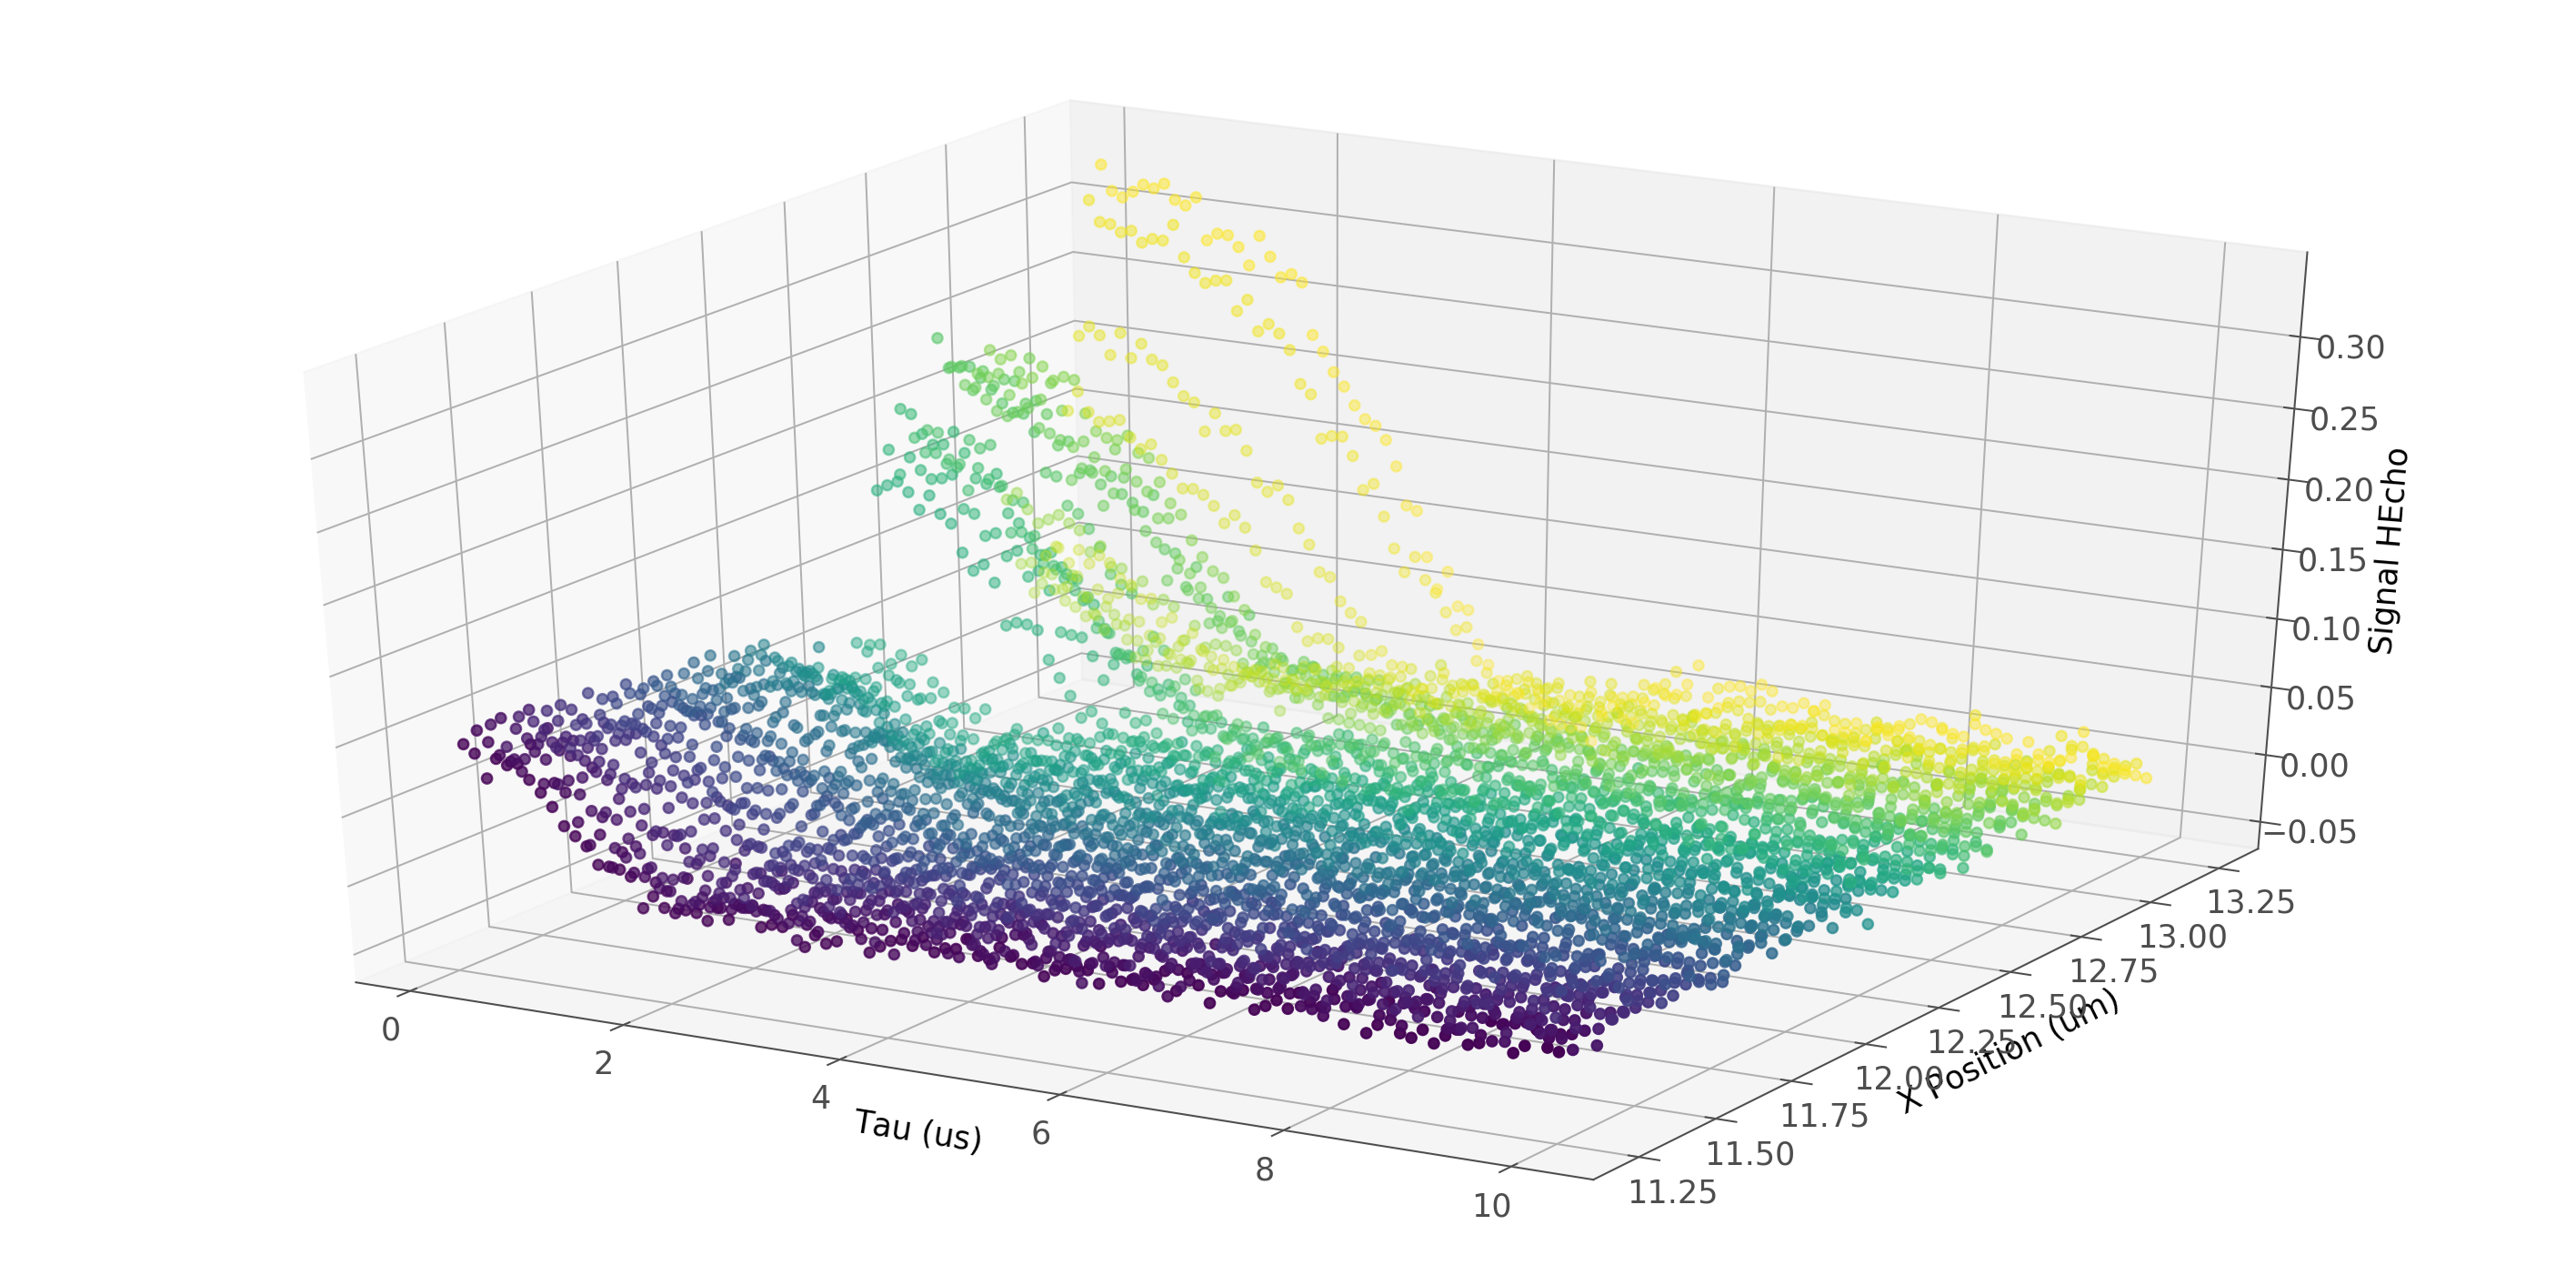

In [8]:
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

cmap = matplotlib.cm.get_cmap('viridis')
norm = matplotlib.colors.Normalize(vmin=0, vmax=data.shape[0])
scan_arr = np.linspace(scan_start,scan_stop,scan_step)
tau_arr = np.linspace(200e-9,10e-6,100)

fig = plt.figure(figsize=(20,10))
ax = plt.axes(projection='3d')
x3d = []
y3d = []
z3d = []
for i in range(data[::].shape[0]):
    rgba = cmap(norm(i))
    x3d.extend(tau_arr*1e6)
    y3d.extend(np.ones_like(tau_arr)*scan_arr[i]*1e6)
    z3d.extend(data[i])
    
ax.scatter3D(x3d, y3d, z3d, c=y3d, cmap="viridis");
ax.set_xlabel("Tau (us)")
ax.set_ylabel("X Position (um)")
ax.set_zlabel("Signal HEcho")
plt.show()

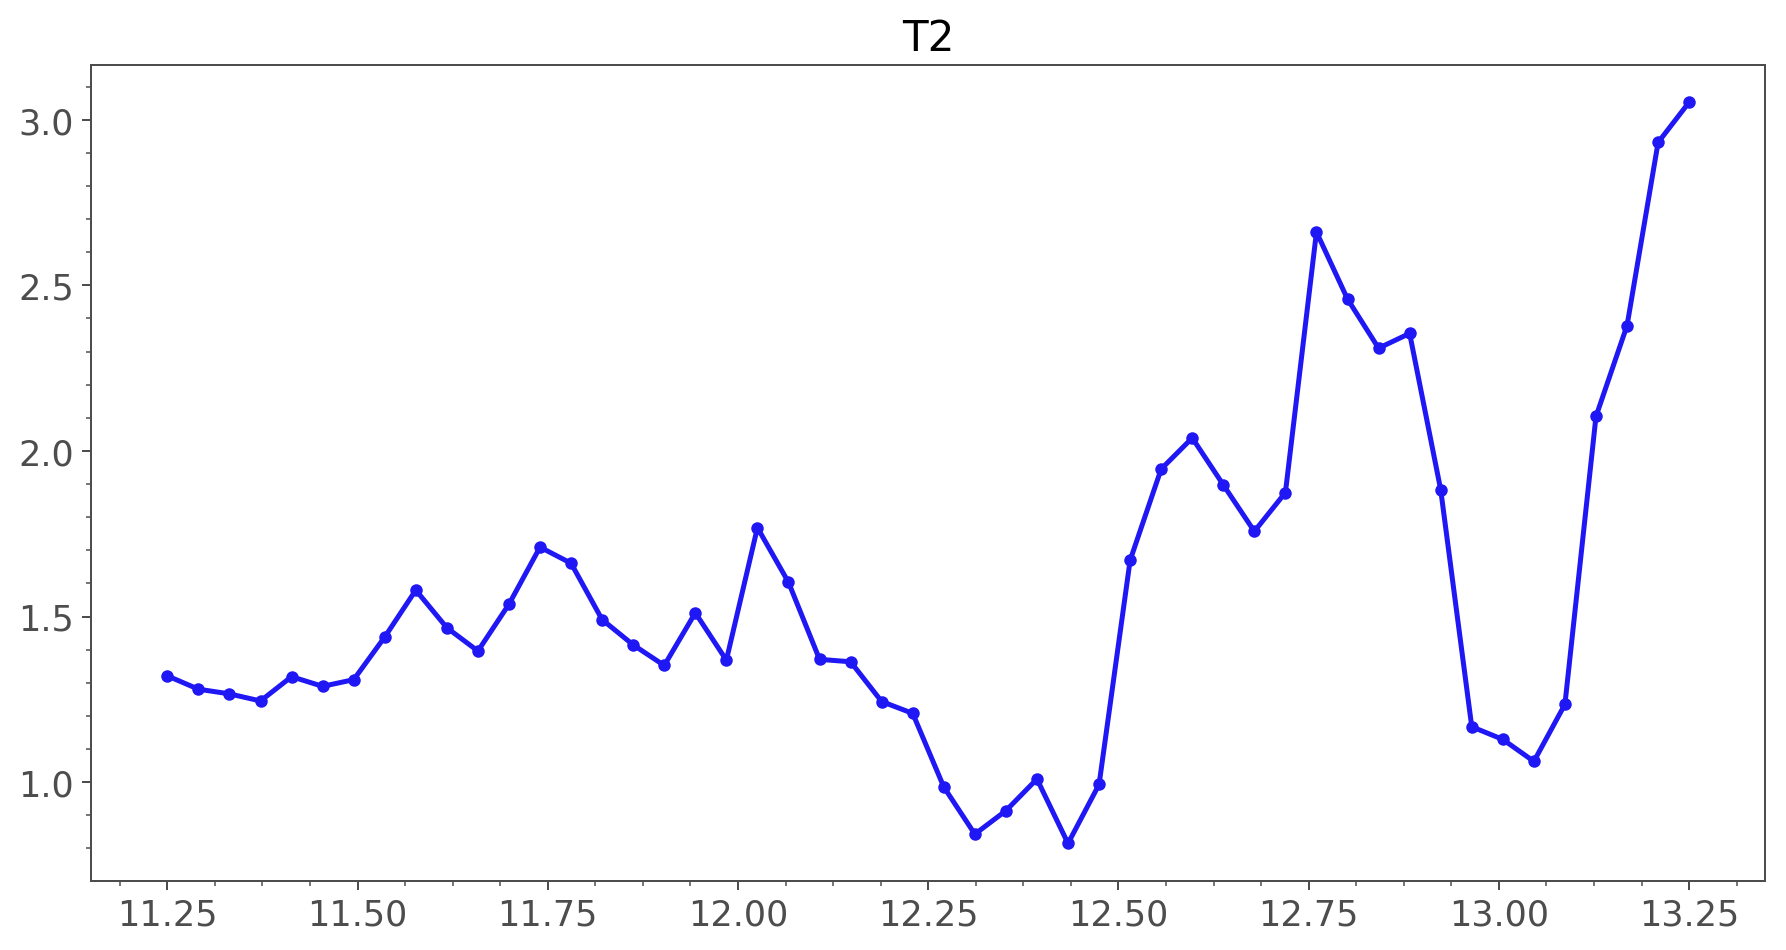

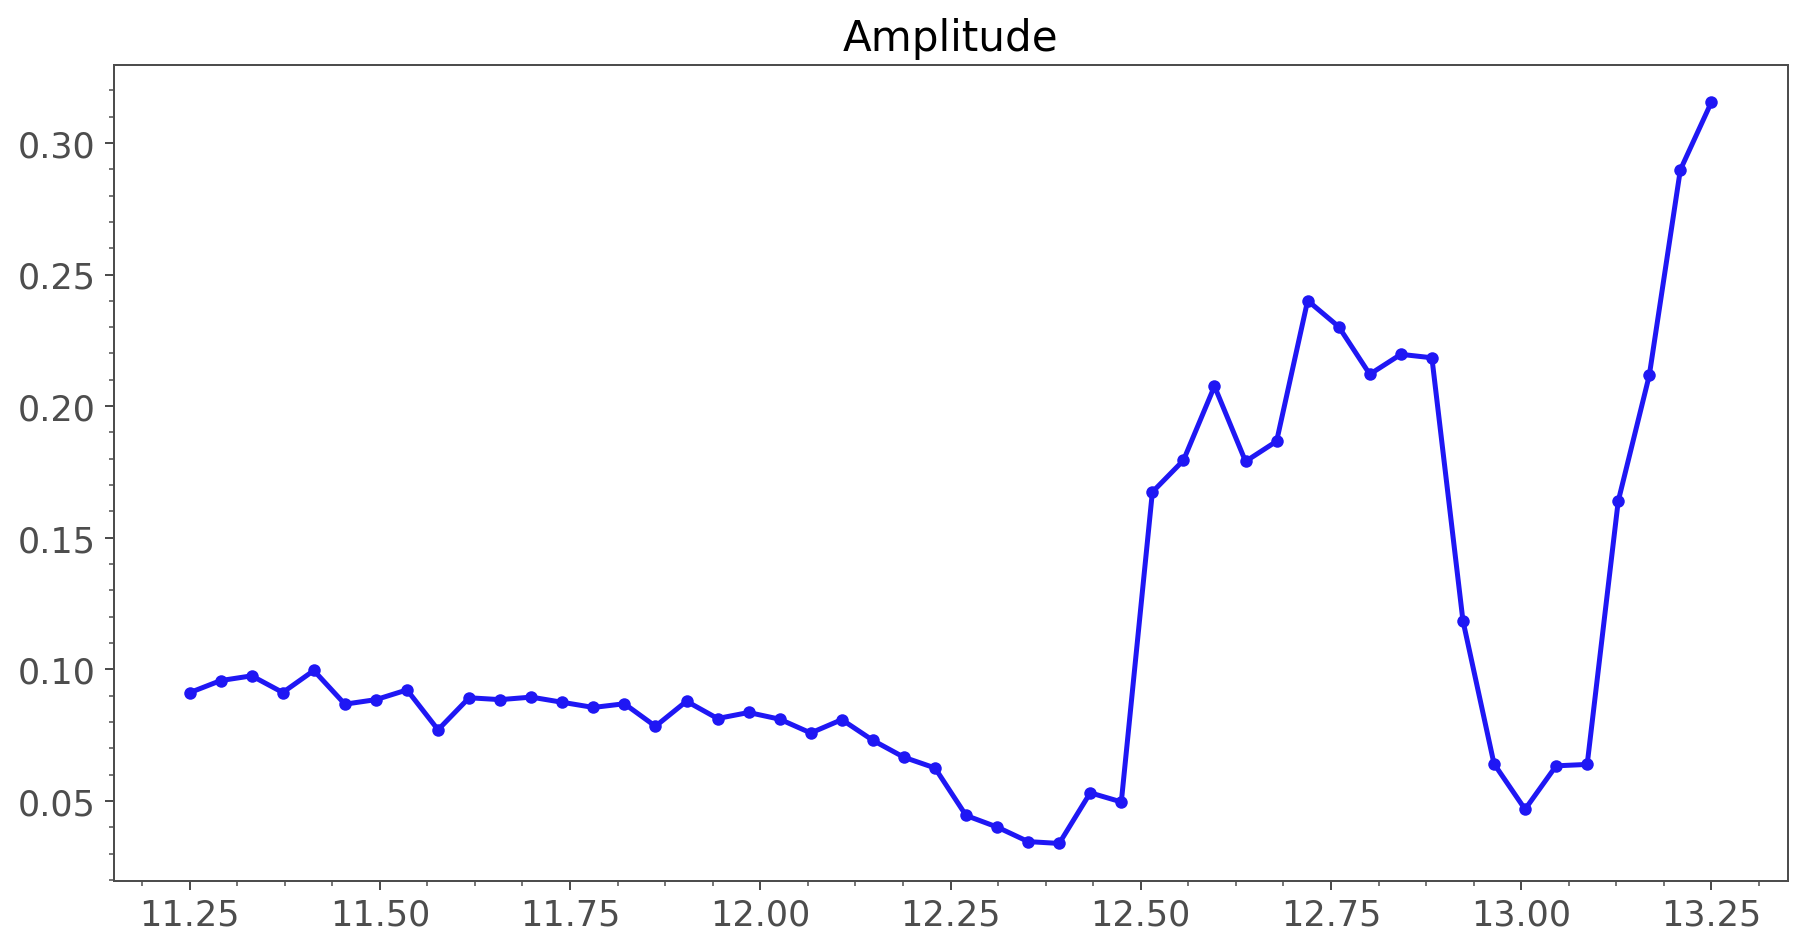

In [9]:
t2s = []
betas = []
for i in range(data[::].shape[0]):
    ydata =  data[i]
    var_list = tau_arr
    fit = afm_scanner_logic._fitlogic.make_decayexponentialstretched_fit(var_list,ydata,estimator=afm_scanner_logic._fitlogic.estimate_decayexponentialstretched)
    lm,_ = fitlogic.make_decayexponentialstretched_model()
    t2s.append(fit.params['lifetime']*1e6)
    betas.append(fit.params['amplitude'])
plt.title("T2")
plt.plot(scan_arr*1e6, t2s)
plt.show()

plt.title("Amplitude")
plt.plot(scan_arr*1e6, betas)
plt.show()

###### Data scrubbing

In [75]:
import glob
base_path = "G:\\Data\\Projects\\NbSe2\\AC studies\\Set E\\8K data"
podmr_paths = glob.glob(base_path + "\\*_PODMR*_pulsed_measurement.dat")
hecho_paths = glob.glob(base_path + "\\*_Hecho*_pulsed_measurement.dat")

In [76]:
podmr_data_scan = []
for idx, path in enumerate(podmr_paths[:]):
    podmr_data = np.loadtxt(path).T
    podmr_data_scan.append(podmr_data)
podmr_data_scan = np.asarray(podmr_data_scan)

hecho_data_scan = []
for idx, path in enumerate(hecho_paths[:]):
    hecho_data = np.loadtxt(path).T
    hecho_data_scan.append(hecho_data)
hecho_data_scan = np.asarray(hecho_data_scan)

###### Save data

In [78]:
import pickle
loc = base_path + f"\\{time.strftime('%Y%m%d-%H%M-%S')}-hecho_all_data"
data = hecho_data_scan
with open(loc + '.pickle', 'wb') as handle:
    b = pickle.dump(data, handle)

######  Read data

In [1]:
base_path = "G:\\Data\\Projects\\NbSe2\\AC studies\\Set E\\2K data"

In [2]:
import pickle
loc = base_path +"\\"+ "20240222-1042-52-hecho_all_data"
with open(loc + '.pickle', 'rb') as handle:
    hecho_data = pickle.load(handle)

In [3]:
import pickle
loc = base_path +"\\"+ "20240222-1044-55-podmr_all_data"
with open(loc + '.pickle', 'rb') as handle:
    podmr_data = pickle.load(handle)

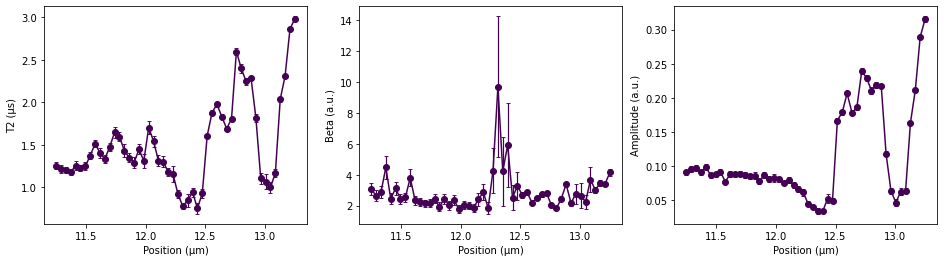

In [4]:
import matplotlib

scan_array = np.linspace(11.25e-6, 13.25e-6, 50)*1e6
t2_IC = {"data":np.zeros(hecho_data.shape[0]),
         "data_err":np.zeros(hecho_data.shape[0]),
         "beta":np.zeros(hecho_data.shape[0]),
         "beta_err":np.zeros(hecho_data.shape[0]),
         "amp":np.zeros(hecho_data.shape[0]),
         "amp_err":np.zeros(hecho_data.shape[0])
        }

cmap = matplotlib.cm.get_cmap('viridis')
norm = matplotlib.colors.Normalize(vmin=0, vmax=hecho_data.shape[0])

fig = plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

# ax1.set_xscale('log')
# ax2.set_xscale('log')

axes = [ax1,ax2,ax3]
data_keys = ["data","pow","amp"]
for idx, data_raw in enumerate(hecho_data):
    var_list = data_raw[0]
    mode = 'exp_decay_stretched'
    plot_option = 3 #1 = Signal1, 2 = Signal2, 3 = delta of signals
    err = None
    #Choose what to plot
    if plot_option == 3:
        data = data_raw[1] - data_raw[2]
        shift = (data_raw.shape[0]-1)//2
        err1 = abs(data_raw[1+shift])
        err2 = abs(data_raw[2+shift])
        err = err1+err2
    else:
        data = data_raw[plot_option]
        shift = (data_raw.shape[0]-1)//2
        err = data_raw[plot_option+shift]
    if mode == 'exp_decay_stretched':
        fit = afm_scanner_logic._fitlogic.make_decayexponentialstretched_fit(var_list,data,estimator=afm_scanner_logic._fitlogic.estimate_decayexponentialstretched)
        lm,_ = fitlogic.make_decayexponentialstretched_model()
#         leg = f"T$_2$: {round(fit.params['lifetime']*1e6,2)} µs $\pm$ {round(fit.params['lifetime'].stderr*1e6,2)} µs"
        t2_IC["data"][idx] = fit.params['lifetime']*1e6
        t2_IC["data_err"][idx] = fit.params['lifetime'].stderr*1e6
        
        t2_IC["beta"][idx] = fit.params['beta']
        t2_IC["beta_err"][idx] = fit.params['beta'].stderr
        
        t2_IC["amp"][idx] = fit.params['amplitude']
        t2_IC["amp_err"][idx] = fit.params['amplitude'].stderr
        

# err = np.sqrt((t2_IC_err/t2_OOC)**2+(t2_IC/t2_OOC**2*t2_OOC_err)**2)
ax1.errorbar(x=scan_array, y=t2_IC["data"],
                yerr=t2_IC["data_err"], fmt='-o',
                capsize=2, capthick=0.9,
                elinewidth=1.2, color=cmap(norm(0)))
ax2.errorbar(x=scan_array, y=t2_IC["beta"],
                yerr=t2_IC["beta_err"], fmt='-o',
                capsize=2, capthick=0.9,
                elinewidth=1.2, color=cmap(norm(0)))
ax3.errorbar(x=scan_array, y=t2_IC["amp"],
                yerr=t2_IC["amp_err"], fmt='-o',
                capsize=2, capthick=0.9,
                elinewidth=1.2, color=cmap(norm(0)))


ax1.set_xlabel('Position (µm)')
ax1.set_ylabel('T2 (µs)')

ax2.set_xlabel('Position (µm)')
ax2.set_ylabel('Beta (a.u.)')

ax3.set_xlabel('Position (µm)')
ax3.set_ylabel('Amplitude (a.u.)')

# ax1.title.set_text('Hahn Echo T2 IC')
# ax2.title.set_text('Hahn Echo Beta IC')
# ax3.title.set_text('Hahn Echo Amplitude IC')
        
# plt.rcParams['figure.figsize'] = (9, 6)
fontsize = 12
plt.show()


In [5]:
np.argmax(t2_IC["beta"])

26

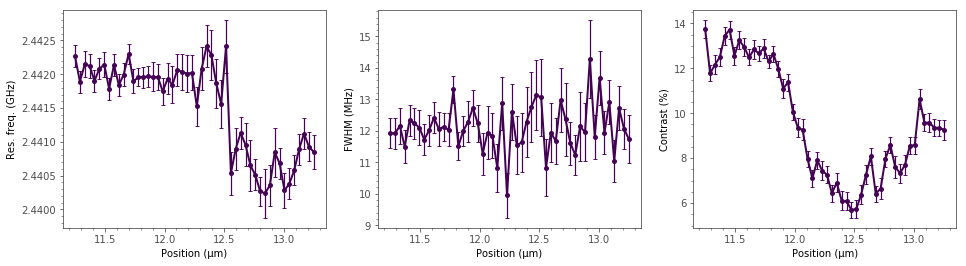

In [43]:
import matplotlib

scan_array = np.linspace(11.25e-6, 13.25e-6, 50)*1e6
podmr_IC = {"data":np.zeros(hecho_data.shape[0]),
         "data_err":np.zeros(hecho_data.shape[0]),
         "fwhm":np.zeros(hecho_data.shape[0]),
         "fwhm_err":np.zeros(hecho_data.shape[0]),
         "contrast":np.zeros(hecho_data.shape[0]),
         "contrast_err":np.zeros(hecho_data.shape[0])
        }

cmap = matplotlib.cm.get_cmap('viridis')
norm = matplotlib.colors.Normalize(vmin=0, vmax=hecho_data.shape[0])

fig = plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

# ax1.set_xscale('log')
# ax2.set_xscale('log')

axes = [ax1,ax2,ax3]
data_keys = ["data","pow","amp"]
for idx, data_raw in enumerate(podmr_data):
    var_list = data_raw[0]
    mode = 'gaussian_dip'
    plot_option = 1 #1 = Signal1, 2 = Signal2, 3 = delta of signals
    err = None
    #Choose what to plot
    if plot_option == 3:
        data = data_raw[1] - data_raw[2]
        shift = (data_raw.shape[0]-1)//2
        err1 = abs(data_raw[1+shift])
        err2 = abs(data_raw[2+shift])
        err = err1+err2
    else:
        data = data_raw[plot_option]
        shift = (data_raw.shape[0]-1)//2
        err = data_raw[plot_option+shift]
    if mode == 'gaussian_dip':
        fit = afm_scanner_logic._fitlogic.make_gaussian_fit(var_list,data,estimator=afm_scanner_logic._fitlogic.estimate_gaussian_dip)
        lm,_ = fitlogic.make_decayexponentialstretched_model()
#         leg = f"T$_2$: {round(fit.params['lifetime']*1e6,2)} µs $\pm$ {round(fit.params['lifetime'].stderr*1e6,2)} µs"
        podmr_IC["data"][idx] = fit.params['center']/1e9
        podmr_IC["data_err"][idx] = fit.params['center'].stderr/1e9
        
        podmr_IC["fwhm"][idx] = fit.params['fwhm']/1e6
        podmr_IC["fwhm_err"][idx] = fit.params['fwhm'].stderr/1e6
        
        podmr_IC["contrast"][idx] = fit.params['contrast']*-1
        podmr_IC["contrast_err"][idx] = fit.params['contrast'].stderr
        

# err = np.sqrt((t2_IC_err/t2_OOC)**2+(t2_IC/t2_OOC**2*t2_OOC_err)**2)
ax1.errorbar(x=scan_array, y=podmr_IC["data"],
                yerr=podmr_IC["data_err"], fmt='-o',
                capsize=2, capthick=0.9,
                elinewidth=1.2, color=cmap(norm(0)))
ax2.errorbar(x=scan_array, y=podmr_IC["fwhm"],
                yerr=podmr_IC["fwhm_err"], fmt='-o',
                capsize=2, capthick=0.9,
                elinewidth=1.2, color=cmap(norm(0)))
ax3.errorbar(x=scan_array, y=podmr_IC["contrast"],
                yerr=podmr_IC["contrast_err"], fmt='-o',
                capsize=2, capthick=0.9,
                elinewidth=1.2, color=cmap(norm(0)))

ax1.set_xlabel('Position (µm)')
ax1.set_ylabel('Res. freq. (GHz)')

ax2.set_xlabel('Position (µm)')
ax2.set_ylabel('FWHM (MHz)')

ax3.set_xlabel('Position (µm)')
ax3.set_ylabel('Contrast (%)')


# ax4.set_xlabel('Temperature (K)')
# ax4.set_ylabel('Beta')

# ax1.title.set_text('PODMR center IC')
# ax2.title.set_text('PODMR fwhm IC')
# ax3.title.set_text('PODMR contrast IC')
        
# plt.rcParams['figure.figsize'] = (9, 6)
fontsize = 12
plt.show()


In [36]:
podmr_contrast_IC_2K = podmr_IC["contrast"]
podmr_contrast_IC_2K_err = podmr_IC["contrast_err"]

In [44]:
podmr_contrast_IC_8K = podmr_IC["contrast"]
podmr_contrast_IC_8K_err = podmr_IC["contrast_err"]

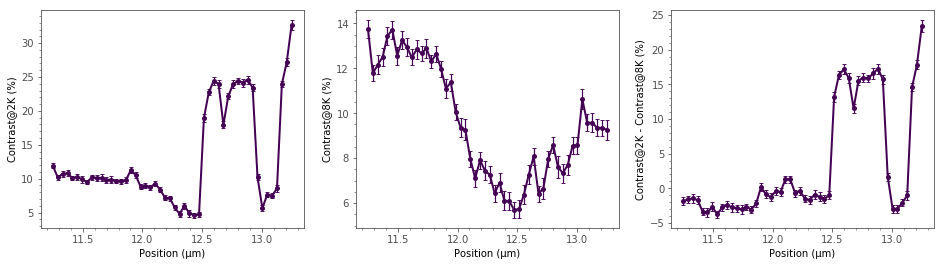

In [52]:
fig = plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

ax1.errorbar(x=scan_array, y=podmr_contrast_IC_2K,
        yerr=podmr_contrast_IC_2K_err, fmt='-o',
        capsize=2, capthick=0.9,
        elinewidth=1.2, color=cmap(norm(0)))

ax2.errorbar(x=scan_array, y=podmr_contrast_IC_8K,
        yerr=podmr_contrast_IC_8K_err, fmt='-o',
        capsize=2, capthick=0.9,
        elinewidth=1.2, color=cmap(norm(0)))

ax3.errorbar(x=scan_array, y=podmr_contrast_IC_2K-podmr_contrast_IC_8K,
        yerr=np.sqrt(podmr_contrast_IC_8K_err**2+podmr_contrast_IC_2K_err**2), fmt='-o',
        capsize=2, capthick=0.9,
        elinewidth=1.2, color=cmap(norm(0)))

ax1.set_xlabel('Position (µm)')
ax1.set_ylabel('Contrast@2K (%)')

ax2.set_xlabel('Position (µm)')
ax2.set_ylabel('Contrast@8K (%)')

ax3.set_xlabel('Position (µm)')
ax3.set_ylabel('Contrast@2K - Contrast@8K (%)')

plt.show()